# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW06] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
import scipy.special
import typing
import math

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказание для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [16]:
class Module:
    def forward(self, x):
        raise NotImplementedError()

    def backward(self, d):
        raise NotImplementedError()

    def update(self, alpha):
        pass


class Linear(Module):
    def __init__(self, in_features, out_features):
        self.W = np.random.uniform(-1, 1, size=(out_features, in_features + 1))
        self.x = None
        self.d = None

    def forward(self, X):
        self.x = copy.deepcopy(X)
        self.x = self.x if len(self.x.shape) > 1 else self.x.reshape(-1, 1)
        self.x = np.vstack((self.x, np.ones((1, self.x.shape[1]))))
        return self.W.dot(self.x)

    def backward(self, d):
        self.d = copy.deepcopy(d)
        return (self.d.T.dot(self.W).T)[:-1]

    def update(self, alpha):
        self.W -= alpha * (self.d.dot(self.x.T))


class ReLU(Module):
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x):
        self.x = copy.deepcopy(x)
        self.x = self.x if len(self.x.shape) > 1 else self.x.reshape(-1, 1)
        self.y = np.maximum(self.x, 0)
        return copy.deepcopy(self.y)

    def backward(self, d):
        pd = copy.deepcopy(self.x)
        pd[pd >= 0] = 1
        pd[pd < 0] = 0
        return pd * d

class Softmax(Module):
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x):
        self.x = copy.deepcopy(x)
        self.x = self.x if len(self.x.shape) > 1 else self.x.reshape(-1, 1)
        self.y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return copy.deepcopy(self.y)

    def backward(self, d):
        sc = self.y.T.dot(d)
        sc = sc[np.arange(len(sc)), np.arange(len(sc))].reshape(1, -1)
        sc = np.repeat(sc, len(self.y), axis=0)
        return self.y * (d - sc)

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [12]:
class MLPClassifier:

    def __init__(self, modules: typing.List[Module], epochs=40, alpha=0.01):
        self.modules = modules + [Softmax()]
        self.epochs = epochs
        self.alpha = alpha

    def forward(self, curx):
        for layer in self.modules:
            curx = layer.forward(curx)
        return curx
        
    def backward(self, curd):
        for layer in reversed(self.modules):
            curd = layer.backward(curd)
            layer.update(self.alpha)
        return curd
        
    def epoch(self):
        curx = self.forward(copy.deepcopy(self.X))
        curd = np.ones_like(curx)
        curd[self.y, np.arange(len(self.y))] = 0
        curd = -(1 - curd) / curx
        curd = np.array(curd)
        self.backward(curd)

    def fit(self, X, y):
        self.X = copy.deepcopy(X)
        if len(self.X.shape) == 1:
            self.X = self.X.reshape(-1, 1)
        self.X = self.X.T
        self.y = copy.deepcopy(np.array(y)).reshape(-1)
        for _ in range(self.epochs):
            self.epoch()

    def predict_proba(self, X):
        return self.forward(copy.deepcopy(X).T).T

    def predict(self, X):
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [17]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Softmax(),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [25]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)
best_acc = 0
for _ in range(25):
    p = MLPClassifier(
        [
            Linear(2, 64),
            ReLU(),
            Linear(64, 64),
            ReLU(),
            Linear(64, 2)
        ],
        alpha = 1e-3
    )

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 1.0


In [28]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier(
        [
            Linear(2, 64),
            ReLU(),
            Linear(64, 64),
            ReLU(),
            Linear(64, 3)
        ],
        alpha = 1e-4
    )

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.955


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [199]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [200]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("./datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("./datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [201]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.lin1 = nn.Linear(16 * 5 * 5, 100)
        self.lin2 = nn.Linear(100, 10)
        self.soft = nn.Softmax(dim=-1);

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return self.soft(x)
        
def calculate_loss(X, y, model):
    return F.cross_entropy(model(X), y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [202]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [203]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.249944390640259 | Test loss 2.169427621459961
Epoch 1 | Train loss 2.141896189880371 | Test loss 2.120697330856323
Epoch 2 | Train loss 2.112155778579712 | Test loss 2.094536739349365
Epoch 3 | Train loss 2.0911382291412353 | Test loss 2.077608288574219
Epoch 4 | Train loss 2.0739021131134034 | Test loss 2.0698890518188477
Epoch 5 | Train loss 2.0616937714385988 | Test loss 2.0518388519287107
Epoch 6 | Train loss 2.0501777337646483 | Test loss 2.0440671966552735
Epoch 7 | Train loss 2.0406595331573487 | Test loss 2.0391583000183107
Epoch 8 | Train loss 2.0333326289367677 | Test loss 2.033728393173218
Epoch 9 | Train loss 2.0253315608978273 | Test loss 2.027433614730835
Epoch 10 | Train loss 2.0195789878845214 | Test loss 2.0172090641021727
Epoch 11 | Train loss 2.011031819000244 | Test loss 2.018103324127197
Epoch 12 | Train loss 2.005444717712402 | Test loss 2.00714349899292
Epoch 13 | Train loss 2.0015360527038575 | Test loss 2.007724580001831
Epoch 14 | Train 

Построим график функции потерь

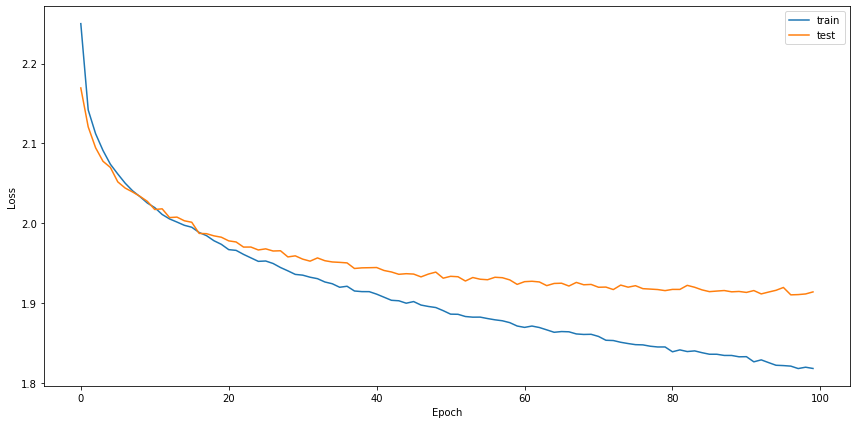

In [204]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [205]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.5447
Precision [0.5943128  0.65600775 0.4718398  0.38023952 0.43833185 0.50496278
 0.57833483 0.54545455 0.70406905 0.58231421]
Recall [0.627 0.677 0.377 0.381 0.494 0.407 0.646 0.648 0.571 0.619]
Mean Precision 0.5455867129006162
Mean Recall 0.5447
